# **DataSource Selection**: Data Source and Event Type Analysis
------------------

## Goals:
1. Identify most relevent data sources based on MITRE ATT&ck Techniques
    * Frequency counts based on all TTPs
    * Frequency counts based on common TTPs (only those TTPs attributed to tracked threat groups)
    * Frequency counts based on modern TTPs (only those TTPs identified in 2019/2020 thrend reports)
    * Map Generic MITRE ATT&ck Data sources to Events
2. Conduct Exploratory Data Analysis on APT29 Detection Hackathon Dataset
3. Identify most relevant data sources and features based on Industry Guidance

## References:
* https://github.com/hunters-forge/ATTACK-Python-Client
* https://github.com/OTRF/detection-hackathon-apt29
* https://infosecjupyterthon.com/notebooks/2_Jupyterthon_Cyb3rPandaH_2020.html
* https://github.com/hunters-forge/ThreatHunter-Playbook
* https://github.com/hunters-forge/OSSEM
* https://www.slideshare.net/attackcon2018 MITRE ATT&CKcon 2.0: Prioritizing Data Sources for Minimum Viable Detection; Keith McCammon, Red Canary 
* https://github.com/keithmccammon/python-attack-utils
* https://github.com/SadProcessor/SomeStuff/blob/master/DerbyCon19/ATTCKnowledge.ps1

### 1. Identify most relevent data sources based on MITRE ATT&ck Techniques
------------------
Utilizing approach in https://github.com/hunters-forge/ATTACK-Python-Client/blob/master/notebooks/ATT%26CK_DataSources.ipynb

In [1]:
from attackcti import attack_client
#import altair as alt
#alt.renderers.enable('notebook')
#import itertools
import pandas as pd, numpy as np
from pandas import json_normalize
import matplotlib.pyplot as plt
import requests
from openhunt import ossem, descriptiveStatistics as ds, visualizations as vis
import warnings
warnings.filterwarnings('ignore')

# Import packages
import os
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

from collections import Counter
import json
import yaml

### 1.A. Frequency counts based on all TTPs
------------------
Reference: https://github.com/hunters-forge/ATTACK-Python-Client
* Using attackcti we can generate a dictionary of MITRE ATT&CK techniques and metadata including datasources

In [2]:
lift = attack_client()
all_techniques = lift.get_techniques(stix_format=False)
all_techniques[0]

{'kill_chain_phases': [{'kill_chain_name': 'mitre-attack',
   'phase_name': 'impact'}],
 'external_references': [{'external_id': 'T1531',
   'source_name': 'mitre-attack',
   'url': 'https://attack.mitre.org/techniques/T1531'},
  {'source_name': 'CarbonBlack LockerGoga 2019',
   'description': 'CarbonBlack Threat Analysis Unit. (2019, March 22). TAU Threat Intelligence Notification – LockerGoga Ransomware. Retrieved April 16, 2019.',
   'url': 'https://www.carbonblack.com/2019/03/22/tau-threat-intelligence-notification-lockergoga-ransomware/'},
  {'description': 'Harbison, M.. (2019, March 26). Born This Way? Origins of LockerGoga. Retrieved April 16, 2019.',
   'source_name': 'Unit42 LockerGoga 2019',
   'url': 'https://unit42.paloaltonetworks.com/born-this-way-origins-of-lockergoga/'}],
 'x_mitre_version': '1.0',
 'technique': 'Account Access Removal',
 'technique_description': 'Adversaries may interrupt availability of system and network resources by inhibiting access to accounts ut

In [3]:
all_techniques[0]['data_sources']

['Windows event logs', 'Process command-line parameters', 'Process monitoring']

In [4]:
all_techniques[0].keys()

dict_keys(['kill_chain_phases', 'external_references', 'x_mitre_version', 'technique', 'technique_description', 'id', 'object_marking_refs', 'type', 'created_by_ref', 'created', 'tactic', 'url', 'matrix', 'technique_id', 'modified', 'data_sources', 'permissions_required', 'platform', 'impact_type', 'technique_detection'])

In [5]:
data_sources_dup = list()
for t in all_techniques:
    # ensure technique has datasources assigned and applies to Windows platform
    if 'data_sources' in t.keys() and 'Windows' in t['platform']:
        for ds in t['data_sources']:
                data_sources_dup.append(ds)
        #print(t['platform'])

In [6]:
len(data_sources_dup)

803

In [7]:
pd.Series(data_sources_dup).value_counts().head(10)

Process monitoring                 156
Process command-line parameters     90
File monitoring                     81
API monitoring                      45
Process use of network              38
Packet capture                      36
Windows Registry                    36
Netflow/Enclave netflow             27
Windows event logs                  26
Authentication logs                 24
dtype: int64

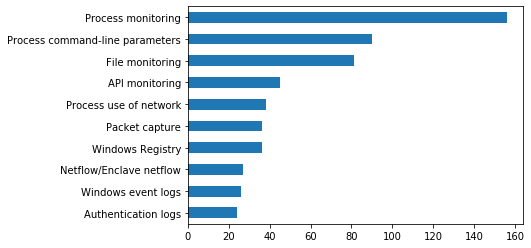

In [8]:
pd.Series(data_sources_dup).value_counts(ascending=True).tail(10).plot(kind='barh')

### 1.B. Frequency counts based on common TTPs (only those TTPs attributed to tracked threat groups)
------------------
Reference: https://github.com/rabobank-cdc/DeTTECT/wiki/Threat-actor-group-mapping
* Using Mitre DeTTECT we can generate a json file with all threat actor data within ATT&CK
* python dettect.py g -> attack_windows_all.json
* This provides us with a subset of techniques attributed to known threat actors.

In [9]:
with open('/home/jake/Documents/output/attack_windows_all.json') as json_file:
    attack_windows_all = json.load(json_file)

In [10]:
#attack_windows_all['techniques']
#for p in attack_windows_all['techniques']:
#    print(p['techniqueID'], p['score'])
    
attack_windows_all_techniques = set()
for p in attack_windows_all['techniques']:
    attack_windows_all_techniques.add(p['techniqueID'])

In [11]:
len(attack_windows_all_techniques)

168

In [12]:
data_sources_dup_attack = list()
for t in all_techniques:
    # ensure technique has datasources assigned and applies to Windows platform
    if 'data_sources' in t.keys() and 'Windows' in t['platform'] and t['technique_id'] in attack_windows_all_techniques:
        for ds in t['data_sources']:
                data_sources_dup_attack.append(ds)
        #print(t['technique_id'])

In [13]:
len(data_sources_dup_attack)

628

In [14]:
pd.Series(data_sources_dup_attack).value_counts().head(10)

Process monitoring                 125
Process command-line parameters     77
File monitoring                     65
Process use of network              36
Packet capture                      30
API monitoring                      27
Windows Registry                    24
Netflow/Enclave netflow             23
Authentication logs                 20
Network protocol analysis           19
dtype: int64

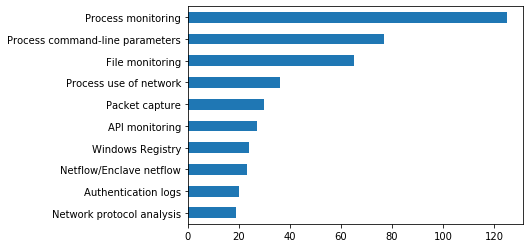

In [15]:
pd.Series(data_sources_dup_attack).value_counts(ascending=True).tail(10).plot(kind='barh')

### 1.C. Frequency counts based on modern TTPs (only those TTPs identified in 2019/2020 thrend reports)
------------------
Reference: https://github.com/rabobank-cdc/DeTTECT/wiki/Threat-actor-group-mapping
* Using Mitre DeTTECT we can utilize their yaml files for modern threat reports.

In [16]:
#!wget https://raw.githubusercontent.com/rabobank-cdc/DeTTECT/master/threat-actor-data/20200220-FireEye.yaml

In [17]:
fireeye_techniques = {'T1040': 1, 'T1201': 1, 'T1007': 1, 'T1124': 1, 'T1480': 1, 'T1158': 1, 'T1093': 1, 'T1031': 1, 'T1023': 1, 'T1081': 1, 'T1214': 1, 'T1111': 1, 'T1491': 1, 'T1173': 1, 'T1106': 1, 'T1170': 1, 'T1179': 1, 'T1049': 1, 'T1497': 1, 'T1036': 1, 'T1117': 1, 'T1096': 1, 'T1482': 1, 'T1135': 1, 'T1140': 1, 'T1168': 1, 'T1077': 1, 'T1490': 1, 'T1492': 1, 'T1014': 2, 'T1094': 2, 'T1047': 2, 'T1138': 2, 'T1055': 2, 'T1058': 2, 'T1188': 2, 'T1219': 2, 'T1021': 2, 'T1496': 2, 'T1083': 3, 'T1046': 3, 'T1057': 3, 'T1016': 3, 'T1054': 3, 'T1004': 3, 'T1015': 3, 'T1087': 4, 'T1069': 4, 'T1034': 4, 'T1012': 4, 'T1038': 4, 'T1073': 4, 'T1099': 4, 'T1102': 4, 'T1022': 4, 'T1192': 4, 'T1136': 5, 'T1486': 5, 'T1033': 5, 'T1116': 5, 'T1090': 5, 'T1070': 5, 'T1060': 5, 'T1110': 5, 'T1193': 5, 'T1082': 6, 'T1089': 6, 'T1112': 7, 'T1063': 7, 'T1199': 7, 'T1059': 8, 'T1489': 8, 'T1045': 9, 'T1003': 9, 'T1071': 10, 'T1098': 10, 'T1107': 11, 'T1105': 11, 'T1053': 11, 'T1078': 11, 'T1202': 13, 'T1002': 13, 'T1032': 14, 'T1100': 16, 'T1190': 17, 'T1076': 19, 'T1133': 28, 'T1035': 28, 'T1086': 29, 'T1064': 30, 'T1027': 31}

In [18]:
set_fireeye_techniques = set(fireeye_techniques)

In [19]:
len(set_fireeye_techniques)

91

In [20]:
data_sources_dup_fireeye = list()
for t in all_techniques:
    # ensure technique has datasources assigned and applies to Windows platform
    if 'data_sources' in t.keys() and 'Windows' in t['platform'] and t['technique_id'] in set_fireeye_techniques:
        for ds in t['data_sources']:
                data_sources_dup_fireeye.append(ds)
        #print(t['technique_id'])

In [21]:
len(data_sources_dup_fireeye)

343

In [22]:
pd.Series(data_sources_dup_fireeye).value_counts().head(10)

Process monitoring                 68
Process command-line parameters    51
File monitoring                    33
Windows Registry                   17
API monitoring                     16
Packet capture                     13
Process use of network             12
Netflow/Enclave netflow            12
Authentication logs                11
Windows event logs                 10
dtype: int64

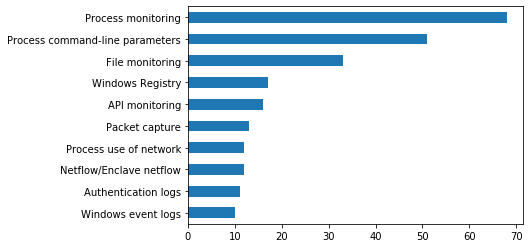

In [23]:
pd.Series(data_sources_dup_fireeye).value_counts(ascending=True).tail(10).plot(kind='barh')

### 1.D. Map Generic MITRE ATT&ck Data sources to Events
------------------
* References: 
    * https://github.com/hunters-forge/OSSEM/tree/master/attack_data_sources
    * https://docs.google.com/spreadsheets/d/1ow7YRDEDJs67kcKMZZ66_5z1ipJry9QrsDQkjQvizJM/edit#gid=0
* Goals:
    * Using hunters-forge/OSSEM identify the events that contribute to MITRE's data sources.

In [24]:
#!wget --no-check-certificate 'https://docs.google.com/spreadsheets/d/1ow7YRDEDJs67kcKMZZ66_5z1ipJry9QrsDQkjQvizJM/export?format=xlsx&id=1ow7YRDEDJs67kcKMZZ66_5z1ipJry9QrsDQkjQvizJM' -O Attack_Data_Modeling.xlsx

In [25]:
attack_data_model = pd.read_excel(open('Attack_Data_Modeling.xlsx', 'rb'), sheet_name='Winevent Logs - ATT&CK')  

In [26]:
attack_data_model.loc[attack_data_model['Data Source'] == 'Process monitoring']

,Data Source,Sub - Data Source,Data Object,Relationship,Data Object.1,Event ID,Description,Provider Name,Event Channel,Data Category,Data Sub-Category,Minimun Operating System,GPO,Enable Commands,Client Default,Server Default
16,Process monitoring,process creation,process,created,process,4688,A new process has been created,Microsoft-Windows-Security-Auditing,Security,Audit Detailed Tracking,Audit Process Creation,"Windows Vista, Windows 2008",Computer Configuration -> Windows Settings -> ...,"auditpol.exe /set /subcategory:""Process Creati...",No auditing,No auditing
17,Process monitoring,process creation,process,created,process,1,Process creation,Microsoft-Windows-Sysmon,Microsoft-windows-sysmon/operational,Process Creation,NaN,"Windows 7, Windows 2008 R2",N/A,Sysmon64.exe -i /Sysmon64.exe -i -l /Sysmon64....,No auditing,No auditing
18,Process monitoring,process termination,user,terminated,process,4689,A process has exited,Microsoft-Windows-Security-Auditing,Security,Audit Detailed Tracking,Audit Process Termination,"Windows Vista, Windows 2008",Computer Configuration -> Windows Settings -> ...,"auditpol.exe /set /subcategory:""Process Termin...",No auditing,No auditing
19,Process monitoring,process termination,process,terminated,NaN,5,The process terminate event reports when a pro...,Microsoft-Windows-Sysmon,Microsoft-windows-sysmon/operational,Process Terminiation,NaN,"Windows 7, Windows 2008 R2",N/A,Sysmon64.exe -i /Sysmon64.exe -i -l / Sysmon64...,No auditing,No auditing
20,Process monitoring,process write to process,process,wrote_to,process,8,The CreateRemoteThread event detects when a pr...,Microsoft-Windows-Sysmon,Microsoft-windows-sysmon/operational,Process Right to Process,CreateRemoteThread,"Windows 7, Windows 2008 R2",N/A,"<CreateRemoteThread onmatch=""exclude"" />",No auditing,No auditing
21,Process monitoring,process access,process,opened,process,10,The process accessed event reports when a proc...,Microsoft-Windows-Sysmon,Microsoft-windows-sysmon/operational,Process Access,Process Opens Another Process,"Windows 7, Windows 2008 R2",N/A,"<ProcessAccess onmatch=""exclude"" />",No auditing,No auditing


In [27]:
ossem.getEventDf(platform = 'windows', provider = 'sysmon', event = 'event-1')

,event_code,title,standard_name,standard_type,name,type,description,sample_value
0,1,Event ID 1: Process creation,tag,TBD,RuleName,string,custom tag mapped to event. i.e ATT&CK techniq...,T1114
1,1,Event ID 1: Process creation,event_date_creation,TBD,UtcTime,date,Time in UTC when event was created,4/11/18 5:25
2,1,Event ID 1: Process creation,process_guid,TBD,ProcessGuid,string,Process Guid of the process that got spawned/c...,{A98268C1-9C2E-5ACD-0000-0010396CAB00}
3,1,Event ID 1: Process creation,process_id,TBD,ProcessId,integer,Process ID used by the os to identify the crea...,4756
4,1,Event ID 1: Process creation,process_path,TBD,Image,string,File path of the process being spawned/created...,C:\Windows\System32\conhost.exe
5,1,Event ID 1: Process creation,file_version,TBD,FileVersion,string,Version of the image associated with the main ...,10.0.16299.15 (WinBuild.160101.0800)
6,1,Event ID 1: Process creation,file_description,TBD,Description,string,Description of the image associated with the m...,Console Window Host
7,1,Event ID 1: Process creation,file_product,TBD,Product,string,Product name the image associated with the mai...,Microsoft® Windows® Operating System
8,1,Event ID 1: Process creation,file_company,TBD,Company,string,Company name the image associated with the mai...,Microsoft Corporation
9,1,Event ID 1: Process creation,file_name_original,TBD,OriginalFileName,string,original file name,wuauclt.exe
